# Data Checks

Quick overview data checks and explorations for a session Treasure Hunt data.

In [1]:
%config Completer.use_jedi = False

In [2]:
# import os
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

# Import spike related utilities from spiketools
from spiketools.measures import compute_spike_rate
from spiketools.spatial.occupancy import compute_occupancy

from spiketools.plts.space import plot_space_heat
from spiketools.plts.spikes import plot_firing_rates

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Define bins to use
bins = [7, 21]

## Load NWB Data

In [5]:
# Load NWB file
io = NWBHDF5IO('nwb_local_data.nwb', 'r')
nwbfile = io.read()

In [6]:
nwbfile

root pynwb.file.NWBFile at 0x140323778820512
Fields:
  acquisition: {
    chest_positions <class 'pynwb.behavior.Position'>,
    chest_stimuli <class 'pynwb.behavior.Position'>,
    chest_trials <class 'pynwb.behavior.Position'>,
    position <class 'pynwb.behavior.Position'>
  }
  data_collection: unknown
  devices: {
    RECORDING DEVICE <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    A-microwires-chnum <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Example conversion to NWB format.
  experimenter: ['XX']
  file_create_date: [datetime.datetime(2021, 10, 19, 11, 38, 53, 527562, tzinfo=tzoffset(None, -14400))]
  identifier: XX
  institution: Columbia
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: U01 Group
  session_description: XX
  session_id: 001
  session_start_time: 2021-10-19 11:38:53.527562-04:00
  subject: subject pynwb.file.Subject at 0x140323847633744


## Position Data

In [7]:
# Extract the position data
pos = nwbfile.acquisition['position']['xy_position']

In [8]:
pos

xy_position pynwb.behavior.SpatialSeries at 0x140323847633072
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (2, 25761), type "<f8">
  description: XY position of the subject along the track.
  interval: 1
  reference_frame: middle
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (25761,), type "<f8">
  timestamps_unit: seconds
  unit: meters

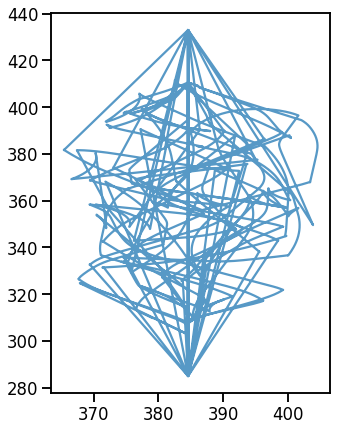

In [9]:
# Plot the map across all position traces
_, ax = plt.subplots(figsize=(5, 7))
ax.plot(*pos.data, alpha=0.75)

In [10]:
# Extract position data
x_data = pos.data[0, :]
y_data = pos.data[1, :]

In [11]:
# Check position ranges
print('x data range: {:6.2f} - {:6.2f}'.format(np.min(x_data), np.max(x_data)))
print('y data range: {:6.2f} - {:6.2f}'.format(np.min(y_data), np.max(y_data)))

x data range: 365.40 - 404.59
y data range: 285.00 - 433.00


In [12]:
# Get speed
# TODO: 
#speed = nwbfile.processing['position_measures']['speed'].data[:]

# TEMP: hack speed (not currently added to file properly)
speed = np.ones(len(pos.timestamps))

## Occupancy

In [13]:
# Compute occupancy values
occ = compute_occupancy(pos.data[:], pos.timestamps[:], bins, speed, set_nan=True)

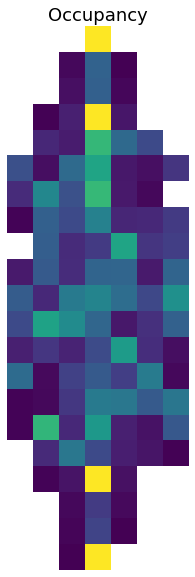

In [14]:
# Plot the occupancy
plot_space_heat(occ, transpose=True, title="Occupancy", vmax=25, figsize=(10, 10))

## Stimuli

In [15]:
# Collect chest positions
chest_pos = nwbfile.acquisition['chest_positions']
chest_xs, chest_ys = chest_pos['chest_positions'].data[:]

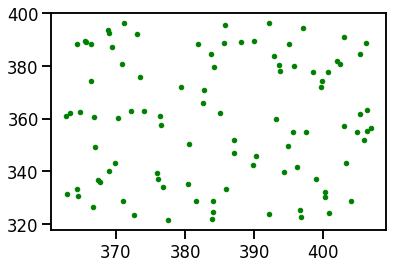

In [16]:
# Plot all chest positions
plt.plot(chest_xs, chest_ys, '.g')

In [17]:
# Collect and check which trial each trial is in
chest_trials = nwbfile.acquisition['chest_trials']
chest_trials = chest_trials['chest_trials'].data[:]
chest_trials

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
       17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21,
       21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23])

In [18]:
# Collect and check which stimulus each chest contains
chest_stim = nwbfile.acquisition['chest_stimuli']
chest_stim = chest_stim['chest_stimuli'].data[:]
chest_stim

array([ 0, 45, 43, 34, 38,  8,  0,  3,  5, 32,  0,  0,  0, 30, 15,  0,  0,
       29, 20, 13, 21, 19,  0,  0, 42, 28,  0,  0, 24,  0,  9,  2, 48,  0,
        4,  0,  0,  1, 49,  0, 14, 37,  0, 27,  6,  0, 11,  0, 26,  0, 23,
        0, 31,  0, 47, 12,  0, 35, 18, 40,  7,  0, 33, 16,  0, 39, 46, 25,
       41,  0, 36,  0, 22,  0, 50,  0, 10, 44,  0, 17,  0, 92, 75, 68,  0,
       70, 83,  0, 52,  0, 67, 77,  0, 86, 53,  0])

## Trials

In [19]:
# Check the data available in the NWB trials section
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x140323847631632
Fields:
  colnames: ['start_time' 'stop_time' 'num_chests' 'num_treasures' 'chest_opening'
 'response']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    num_chests <class 'hdmf.common.table.VectorData'>,
    num_treasures <class 'hdmf.common.table.VectorData'>,
    chest_opening <class 'hdmf.common.table.VectorData'>,
    response <class 'hdmf.common.table.VectorData'>
  )
  description: experimental trials
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

In [20]:
# Check the number of trials in the dataset
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 23


In [21]:
# Get the trial information as a dataframe
behav = nwbfile.trials.to_dataframe()
behav.head()

,start_time,stop_time,num_chests,num_treasures,chest_opening,response
id,,,,,,
0,1.623402e+12,1.623402e+12,4,3,"[1623402123144.3398, 1623402129079.3958, 16234...","[1623402158504.673, 1623402163884.7239, 162340..."
1,1.623402e+12,1.623402e+12,4,3,"[1623402188671.9578, 1623402196052.0273, 16234...","[1623402226296.3125, 1623402230136.3486, 16234..."
2,1.623402e+12,0.000000e+00,4,2,"[1623402260665.6365, 1623402264720.6748, 16234...","[1623402291785.9302, 1623402298817.9963, 0.0]"
3,1.623402e+12,0.000000e+00,4,2,"[1623402313072.1309, 1623402317509.1726, 16234...","[1623402345101.4329, 1623402352308.5007, 0.0]"
4,1.623402e+12,1.623402e+12,4,3,"[1623402364645.6172, 1623402368486.6533, 16234...","[1623402396626.9187, 1623402400257.953, 162340..."


## Check Unit Data

In [22]:
# Check the data available in the NWB units section
nwbfile.units

units pynwb.misc.Units at 0x140323847778656
Fields:
  colnames: ['channel' 'spike_times' 'electrodes']
  columns: (
    channel <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  )
  description: Autogenerated by NWBFile
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [23]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 81


In [24]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(nwbfile.units.spike_times.shape[0]))

Total number of spikes: 311316


In [25]:
# Calculate the average overall firing rate of each neuron
rates = [compute_spike_rate(nwbfile.units.get_unit_spike_times(s_ind) / 1000000) \
         for s_ind in range(n_units)]

In [26]:
# Count the number of units per wire
channel_counts = Counter(nwbfile.units.channel[:])
counts_per_wire = Counter(channel_counts.values())

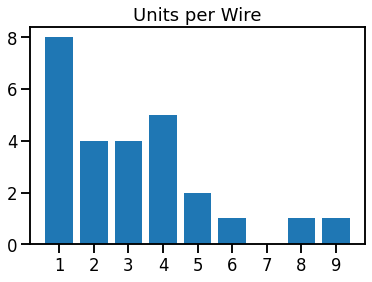

In [27]:
# Plot the distribution of units per wire
plt.bar(counts_per_wire.keys(), counts_per_wire.values())
plt.xticks(list(range(min(counts_per_wire.keys()), max(counts_per_wire.keys()) + 1)));
plt.title('Units per Wire');

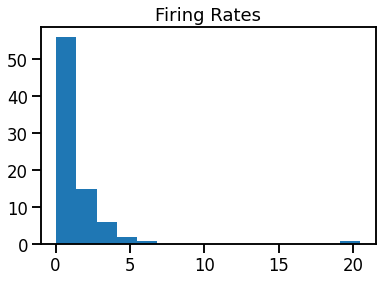

In [28]:
# Check a histogram of the firing rates
plt.hist(rates, bins=15);
plt.title('Firing Rates');

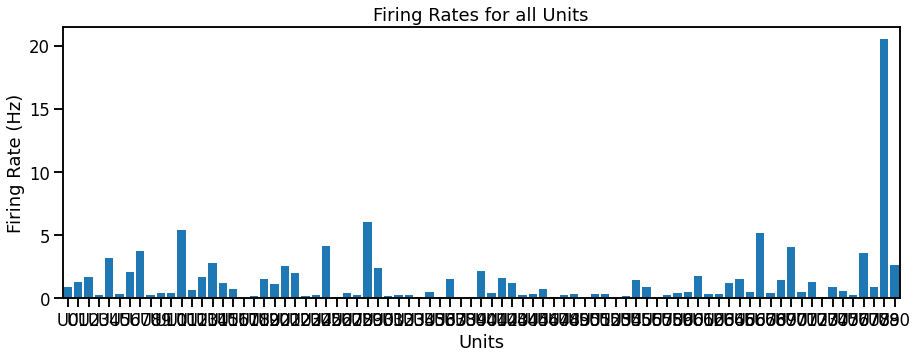

In [29]:
# Plot approximate firing rate for each unit
plot_firing_rates(rates, figsize=(15, 5))

In [30]:
# Get the time range of spike activity
first_spike = np.min(nwbfile.units.spike_times[:])
last_spike = np.max(nwbfile.units.spike_times[:])
dur = last_spike - first_spike

In [31]:
# Collect session normalized spiking activity across all units
all_spikes = []
for uind in range(n_units):
    spikes = nwbfile.units.get_unit_spike_times(uind) - first_spike
    all_spikes.append(spikes / 1000)

(-1.0, 81.0)

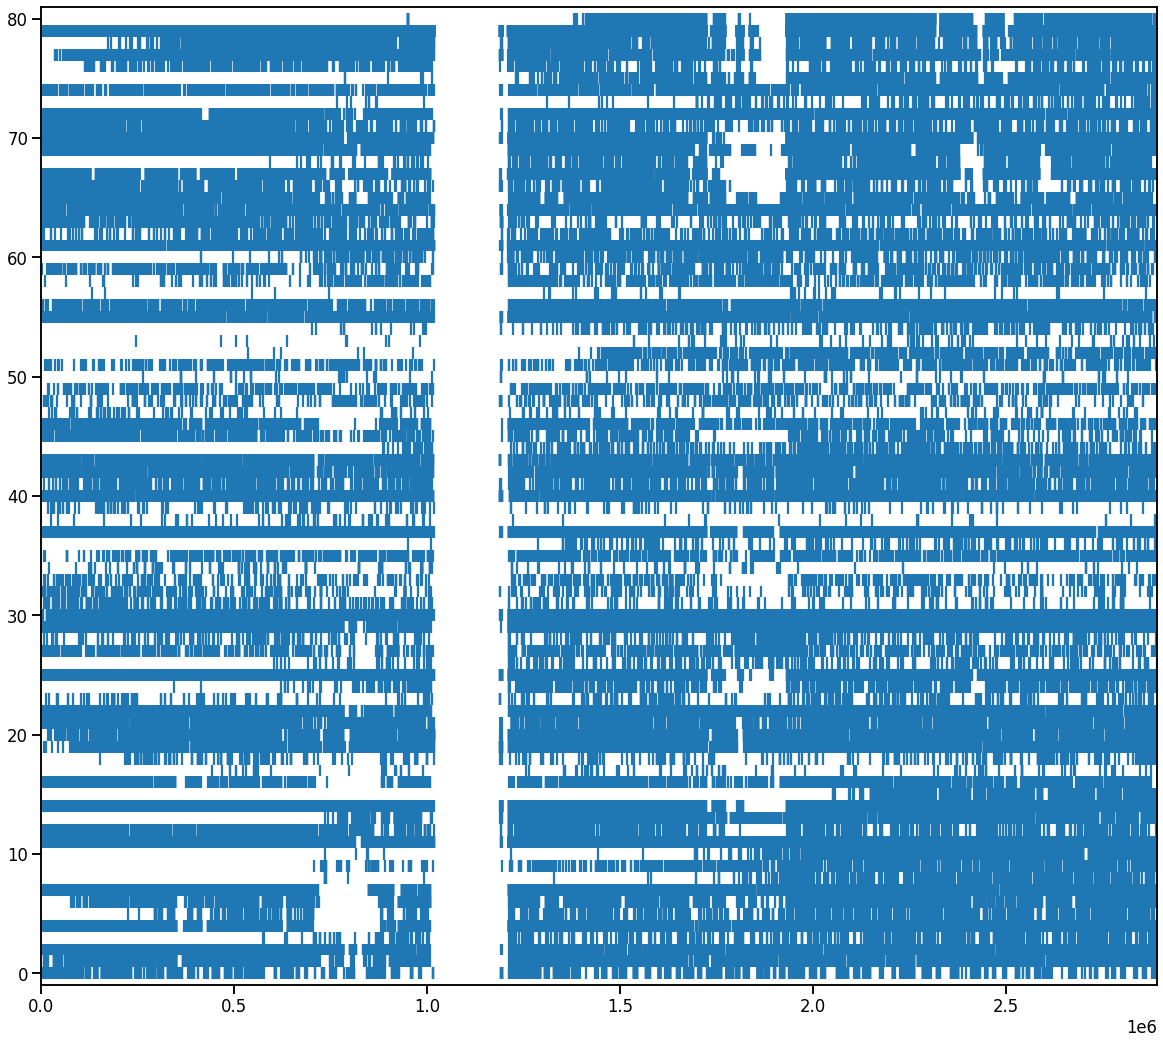

In [32]:
# Plot the session-level raster plot across all units together
_, ax = plt.subplots(figsize=(20, 18))
ax.eventplot(all_spikes);
ax.set_xlim(0, dur/1000)
ax.set_ylim(-1, 81)

In [33]:
# # Print out the whole-session spike raster for each neuron separately
# for uind in range(n_units):
#     spikes = nwbfile.units.get_unit_spike_times(uind) - first_spike
#     plt.figure()
#     plt.eventplot(spikes / 1000)
#     plt.xlim(0, dur/1000)